<a href="https://colab.research.google.com/github/manikur/R-programming/blob/main/evergrande_stock_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#China Evergrande Group (3333.HK)


In [1]:
!pip install yfinance

     |████████████████████████████████| 6.3 MB 52.9 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=03668aa081640d5dd83b9c1a8cd3a7c2d6283a94e088f5c0d229027715e58d53
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [23]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [15]:
df = yf.download('3333.HK',
 start='2012-01-01',
 end='2021-09-25',
 progress=False)


In [12]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,3.27,3.33,3.23,3.25,1.742387,24431314
2012-01-04,3.27,3.28,3.06,3.07,1.645886,37786103
2012-01-05,3.07,3.12,2.98,2.99,1.602996,50452518
2012-01-06,2.98,3.04,2.96,3.03,1.624441,21649245
2012-01-09,3.00,3.15,2.97,3.13,1.678053,39517727
...,...,...,...,...,...,...
2021-09-17,2.62,2.63,2.28,2.54,2.540000,215993769
2021-09-20,2.50,2.53,2.06,2.28,2.280000,133605599
2021-09-21,2.36,2.36,2.12,2.27,2.270000,171239169


In [16]:
df = df.loc[:, ['Adj Close']]
df.rename(columns={'Adj Close':'adj_close'}, inplace=True)

In [17]:
df['simple_rtn'] = df.adj_close.pct_change()
df['log_rtn'] = np.log(df.adj_close/df.adj_close.shift(1))

In [19]:
def realized_volatility(x):
 return np.sqrt(np.sum(x**2))
df_rv = df.groupby(pd.Grouper(freq='M')).apply(realized_volatility)
df_rv.rename(columns={'log_rtn': 'rv'}, inplace=True)
df_rv.rv = df_rv.rv * np.sqrt(12)

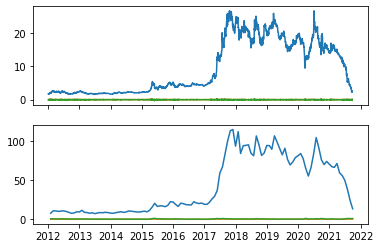

In [24]:
fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(df)
ax[1].plot(df_rv)
   

[Text(0, 0.5, 'Log returns (%)'), Text(0.5, 0, 'Date')]

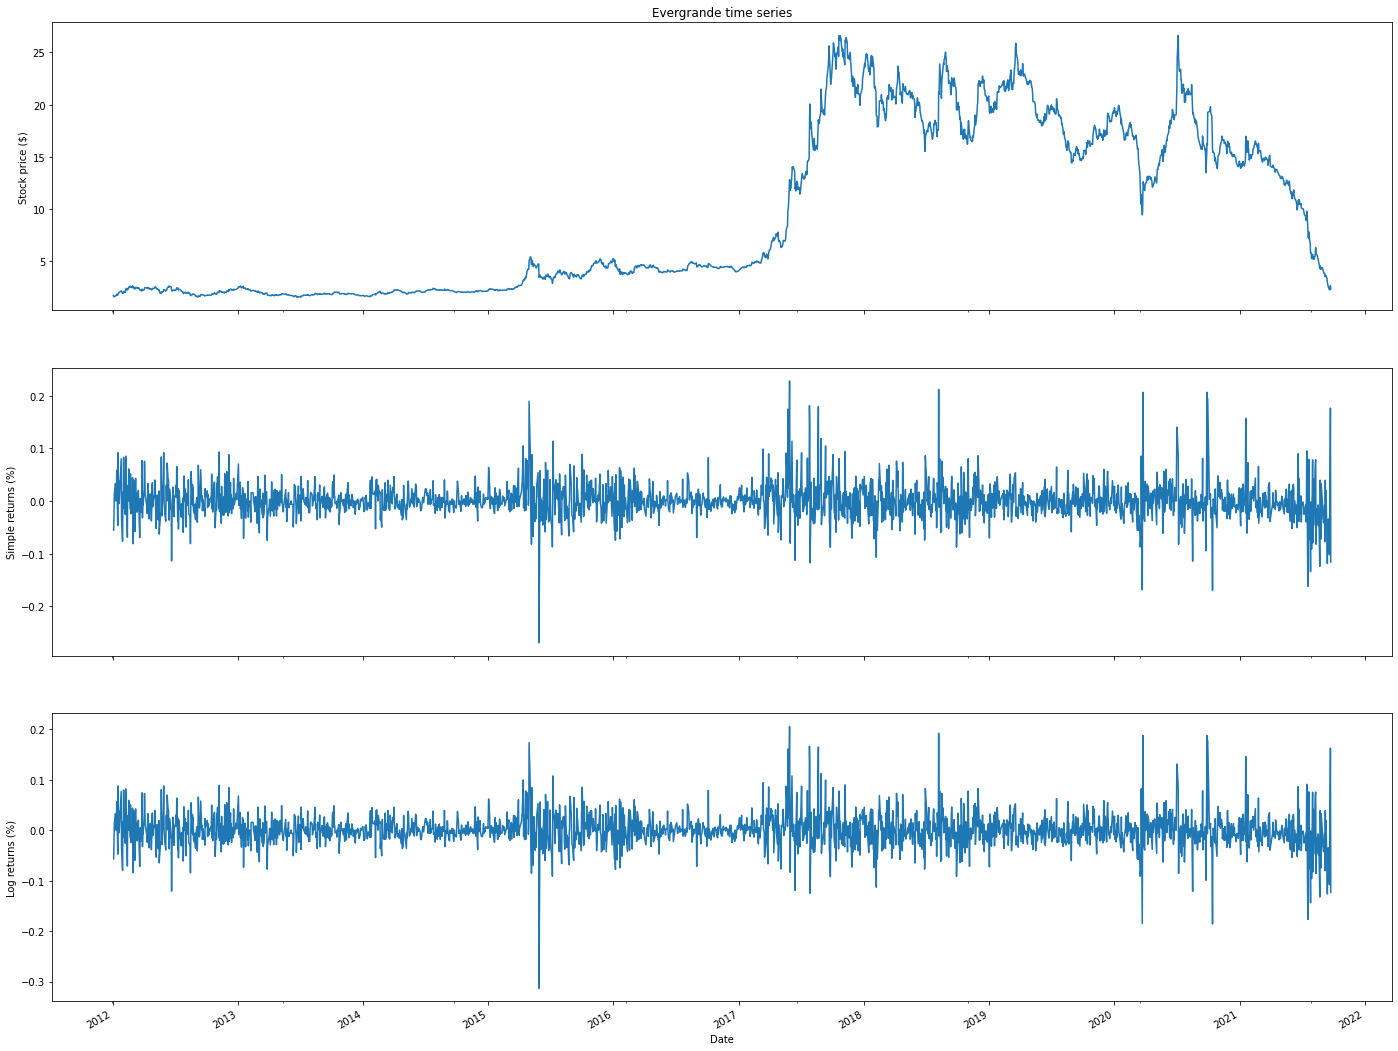

In [25]:
fig, ax = plt.subplots(3, 1, figsize=(24, 20), sharex=True)
df.adj_close.plot(ax=ax[0])
ax[0].set(title = 'Evergrande time series',
 ylabel = 'Stock price ($)')
df.simple_rtn.plot(ax=ax[1])
ax[1].set(ylabel = 'Simple returns (%)')
df.log_rtn.plot(ax=ax[2])
ax[2].set(xlabel = 'Date',
 ylabel = 'Log returns (%)')

The resulting plot contains three axes. Each one of them presents a different series: raw
prices, simple returns, and log returns. Inspecting the plot in such a setting enables us to see
the periods of heightened volatility and what was happening at the same time with the
price of Evergrande stock. Additionally, we see how similar simple and log returns are.

#Calculate the rolling mean and standard deviation:Evergrande stock

In [27]:
df_rolling = df[['simple_rtn']].rolling(window=21) \
 .agg(['mean', 'std'])
df_rolling.columns = df_rolling.columns.droplevel()
df_outliers = df.join(df_rolling)


In [29]:
def indentify_outliers(row, n_sigmas=3):
 x = row['simple_rtn']
 mu = row['mean']
 sigma = row['std']
 if (x > mu + 3 * sigma) | (x < mu - 3 * sigma):
  return 1
 else:
  return 0

In [30]:
df_outliers['outlier'] = df_outliers.apply(indentify_outliers,
 axis=1)
outliers = df_outliers.loc[df_outliers['outlier'] == 1,
 ['simple_rtn']]


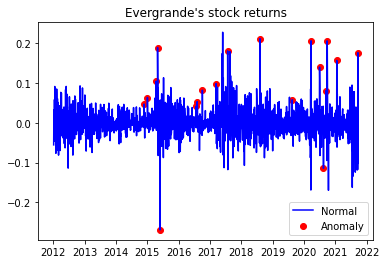

In [32]:
fig, ax = plt.subplots()
ax.plot(df_outliers.index, df_outliers.simple_rtn,
 color='blue', label='Normal')
ax.scatter(outliers.index, outliers.simple_rtn,
 color='red', label='Anomaly')
ax.set_title("Evergrande's stock returns")
ax.legend(loc='lower right')


In the plot, we can observe outliers marked with a red dot. One thing to notice is
that when there are two large returns in the vicinity, the algorithm identifies the
first one as an outlier and the second one as a regular observation. This might be
due to the fact that the first outlier enters the rolling window and affects the
moving average/standard deviation.